In [1]:
import os
import requests

from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cdc_wrapper import CDC

In [2]:
load_dotenv()

api_key = os.getenv('CDCEX_API')
secret_key = os.getenv('CDCEX_SECRET')

cdc = CDC(api_key=api_key, secret_key=secret_key, sandbox=False)
data = cdc.get_candlesticks('ETHUSD-PERP', '1D', 365)
# data

In [3]:
df = pd.DataFrame(data)
df['dt'] = pd.to_datetime(df['t'], unit='ms')
df['o'] = df['o'].astype(float)
df['h'] = df['h'].astype(float)
df['l'] = df['l'].astype(float)
df['c'] = df['c'].astype(float)
df['v'] = df['v'].astype(float)
df['date'] = df['dt'].dt.date
df.head()

,o,h,l,c,v,t,dt,date
0,1634.36,1701.60,1628.65,1679.21,61978.0377,1692748800000,2023-08-23,2023-08-23
1,1679.18,1683.26,1635.13,1660.59,44583.0578,1692835200000,2023-08-24,2023-08-24
2,1660.64,1676.45,1634.86,1653.28,51075.1499,1692921600000,2023-08-25,2023-08-25
3,1653.32,1655.21,1643.43,1646.41,11100.6098,1693008000000,2023-08-26,2023-08-26
4,1646.42,1659.60,1645.48,1657.84,15467.2783,1693094400000,2023-08-27,2023-08-27


In [4]:
base_url = 'https://api.alternative.me/'
endpoint = 'fng/'
limit = 365

request = f'{base_url}{endpoint}?limit={limit}&format=json&date_format=cn'

response = requests.get(request).json()
fng_data = response['data']

fng_df = pd.DataFrame.from_records(fng_data)
fng_df['date'] = pd.to_datetime(fng_df['timestamp']).dt.date
fng_df = fng_df.drop(columns=['time_until_update', 'timestamp'])

fng_df['value'] = pd.to_numeric(fng_df['value'])

print(fng_df)


     value value_classification        date
0       71                Greed  2024-06-17
1       71                Greed  2024-06-16
2       74                Greed  2024-06-15
3       74                Greed  2024-06-14
4       70                Greed  2024-06-13
..     ...                  ...         ...
360     65                Greed  2023-06-23
361     65                Greed  2023-06-22
362     59                Greed  2023-06-21
363     49              Neutral  2023-06-20
364     47              Neutral  2023-06-19

[365 rows x 3 columns]


In [134]:
atr_n = 14

class Position:
    def __init__(self, instrument, open_price, stop_loss, take_profit, qty, direction):
        self.instrument = instrument
        self.open_price = open_price
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.qty = qty
        # short or long
        self.direction = direction
        self.status = 'open'

    def calculate_cost(self):
        return (self.open_price * self.qty)

    def close_position(self, action) -> float:
        self.status = 'closed'
        if action == 'sl':
            if self.direction == 'long':
                return ((self.stop_loss * self.qty) - self.calculate_cost())
            if self.direction == 'short':
                return -((self.stop_loss * self.qty) - self.calculate_cost())
        elif action == 'tp':
            if self.direction == 'long':
                return ((self.take_profit * self.qty) - self.calculate_cost())
            if self.direction == 'short':
                return -((self.take_profit * self.qty) - self.calculate_cost())

def generate_indicators(df):
    # we need FNG, ATR
    temp_df = df.copy()
    temp_df = temp_df.merge(fng_df, how='left', on='date')
    temp_df = temp_df.rename({
        'value_classification': 'fng_cls',
        'value': 'fng'
    }, axis=1)
    temp_df['c1'] = temp_df['c'].shift(1)
    temp_df['tr1'] = temp_df['h'] - temp_df['l']
    temp_df['tr2'] = np.abs(temp_df['h'] - temp_df['c1'])
    temp_df['tr3'] = np.abs(temp_df['l'] - temp_df['c1'])
    temp_df['tr'] = temp_df[['tr1', 'tr2', 'tr3']].max(axis=1)
    temp_df['atr'] = temp_df['tr'].rolling(window=atr_n, min_periods=1).mean()

    temp_df = temp_df.drop(['c1', 'tr1', 'tr2', 'tr3'], axis=1)

    return temp_df

# random for now, just to test
def calculate_trade(idx, row, levels, rr_ratio):
    levels2 = sorted([level[1] for level in levels])
    if row['fng_cls'] in ['Greed', 'Extreme Greed']:
        for level in levels:
            if level[0] < idx:
                level_val = level[1]
                level_high = level[1] * 1.0075
                level_low = level[1] * 0.9925
                if (row['c'] > level_low) & (row['c'] < level_high):
                    for i, level2 in enumerate(levels2):
                        if level2 == level_val:
                            if (i == 0) or (i == (len(levels2)-1)):
                                break
                            stop_loss = levels2[i-1]
                            take_profit = levels2[i+1]
                            stop_loss -= row['atr']
                            take_profit -= row['atr']
                            # print(f'Potential trade!\nTP: {take_profit}\nSL: {stop_loss}\nPrice: {row["c"]}\nRatio: {(take_profit / row["c"]) / (row["c"] / stop_loss)}')
                            if ((take_profit / row['c']) / (row['c'] / stop_loss)) > rr_ratio:
                                return {
                                    'direction': 'long',
                                    'stop loss': stop_loss,
                                    'take profit': take_profit
                                }
                            else:
                                return {
                                    'direction': 'no trade',
                                    'stop loss': 'na',
                                    'take profit': 'na'
                                }
                            break
    elif row['fng_cls'] in ['Fear', 'Extreme Fear']:
        for level in levels:
            if level[0] < idx:
                level_val = level[1]
                level_high = level[1] * 1.0075
                level_low = level[1] * 0.9925
                if (row['c'] > level_low) & (row['c'] < level_high):
                    for i, level2 in enumerate(levels2):
                        if level2 == level_val:
                            if (i == 0) or (i == (len(levels2)-1)):
                                break
                            stop_loss = levels2[i+1]
                            take_profit = levels2[i-1]
                            stop_loss += row['atr']
                            take_profit += row['atr']
                            # print(f'Potential trade!\nTP: {take_profit}\nSL: {stop_loss}\nPrice: {row["c"]}\nRatio: {(row["c"] / take_profit) / (stop_loss / row["c"])}')
                            if ((row['c'] / take_profit) / (stop_loss / row['c'])) > rr_ratio:
                                return {
                                    'direction': 'short',
                                    'stop loss': stop_loss,
                                    'take profit': take_profit
                                }
                            else:
                                return {
                                    'direction': 'no trade',
                                    'stop loss': 'na',
                                    'take profit': 'na'
                                }
                            break
    return {
        'direction': 'no trade',
        'stop loss': 'na',
        'take profit': 'na'
    }




In [68]:
test_df = generate_indicators(df).copy()
test_df['c_1'] = test_df['c'].shift(1)
test_df['c_rel'] = test_df['c'] / test_df['c_1'] - 1
test_df['c_7'] = test_df['c'].shift(7)
test_df['c_rel7'] = test_df['c'] / test_df['c_7'] - 1
test_df['fng_cls_label'] = test_df['fng_cls'].replace({
    'Extreme Fear': '1. Extreme Fear',
    'Fear': '2. Fear',
    'Neutral': '3. Neutral',
    'Greed': '4. Greed',
    'Extreme Greed': '5. Extreme Greed'
})
test_df['fng_cls_label_1'] = test_df['fng_cls_label'].shift(1)
test_df = test_df.dropna()

test_df['pivot'] = (test_df['h'].rolling(90).max() + test_df['l'].rolling(90).min() + test_df['c'].rolling(90).mean()) / 3
test_df['resistance1'] = 2 * test_df['pivot'] - test_df['l']
test_df['support1'] = 2 * test_df['pivot'] - test_df['h']
test_df['resistance2'] = test_df['pivot'] + (test_df['h'] - test_df['l'])
test_df['support2'] = test_df['pivot'] - (test_df['h'] - test_df['l'])
test_df['pivot'] = test_df['pivot'].shift(1)
test_df['resistance1'] = test_df['resistance1'].shift(1)
test_df['resistance2'] = test_df['resistance2'].shift(1)
test_df['support1'] = test_df['support1'].shift(1)
test_df['support2'] = test_df['support2'].shift(1)


def identify_hozizontal_levels(df, window, threshold):
    levels = []
    for i in range(window, len(df) - window):
        if df['c'].iloc[i] == df['c'].iloc[i-window:i+window+1].min():
            levels.append((df.index[i], df['c'].iloc[i]))

        if df['c'].iloc[i] == df['c'].iloc[i-window:i:window+1].max():
            levels.append((df.index[i], df['c'].iloc[i]))

    filtered_levels = []
    for level in levels:
        if len(filtered_levels) == 0:
            filtered_levels.append(level)
        else:
            if all(abs(level[1] - filtered_level[1]) > threshold for filtered_level in filtered_levels):
                filtered_levels.append(level)

    return filtered_levels

def calculate_fib_levels(df, lookback):
    high = df['c'].loc[-lookback:].max()
    low = df['c'].loc[-lookback:].min()
    diff = high - low

    levels = {
        '0.0%': high,
        '23.6%': high - diff * 0.236,
        '38.2%': high - diff * 0.382,
        '50.0%': high - diff * 0.5,
        '61.8%': high - diff * 0.618,
        '100.0%': low
    }

    return levels          


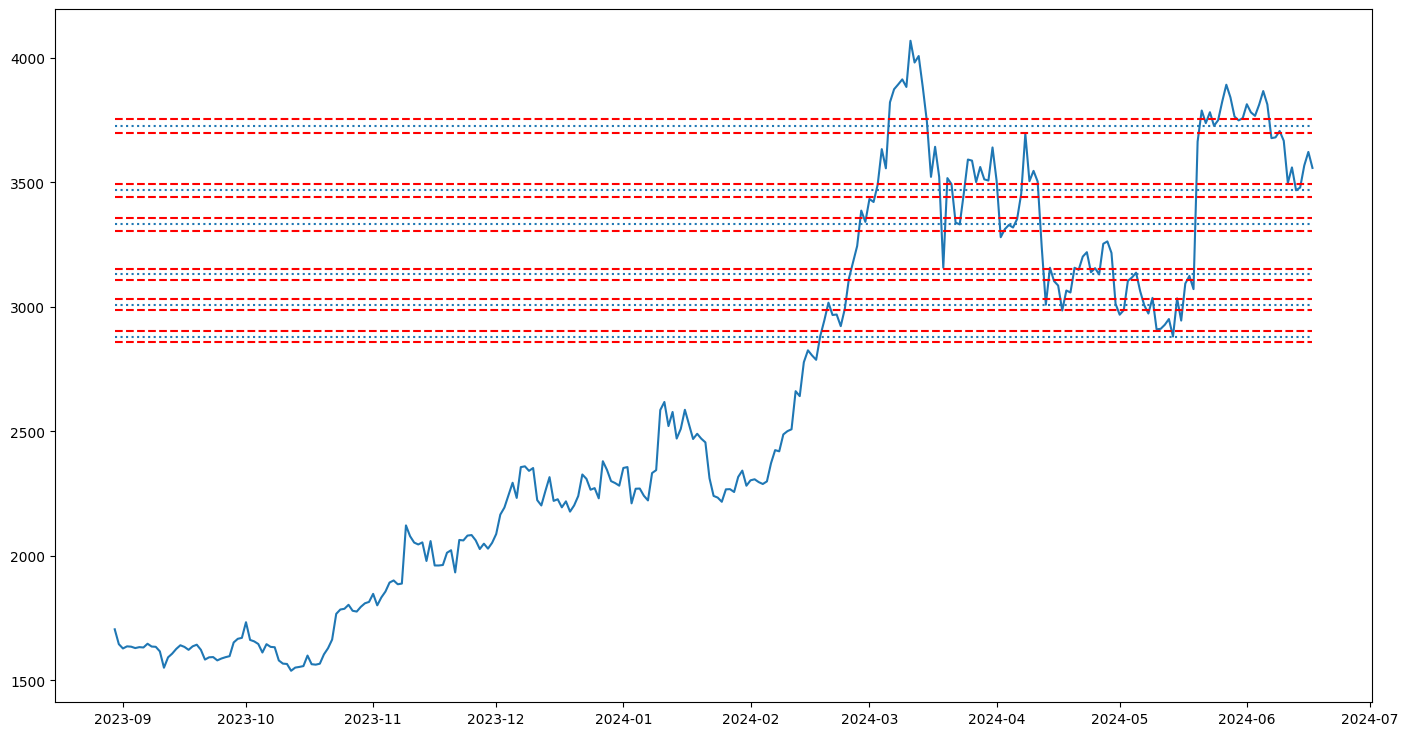

In [81]:
fig, ax = plt.subplots(figsize=(17,9))
plt.plot(test_df['date'], test_df['c'], label='Close')
levels = identify_hozizontal_levels(test_df.iloc[-90:], window=3, threshold=test_df['c'].max()*0.025)
for level in levels:
    plt.hlines(level[1], test_df['date'].min(), test_df['date'].max(), linestyle=':')  
    plt.hlines(level[1] * 1.0075, test_df['date'].min(), test_df['date'].max(), linestyle='--', color='r')
    plt.hlines(level[1] * 0.9925, test_df['date'].min(), test_df['date'].max(), linestyle='--', color='r')
# fib_levels = calculate_fib_levels(test_df, 90)
# for fib_level in fib_levels.values():
#     plt.hlines(fib_level, test_df['date'].min(), test_df['date'].max(), linestyle='--', color='red', alpha=0.8)
# plt.plot(test_df['date'], test_df['pivot'], label='P', linestyle='--')
# # plt.plot(test_df['date'], test_df['support1'], label='S1', linestyle='--', color='grey')
# plt.plot(test_df['date'], test_df['support2'], label='S2', linestyle='--', color='grey')
# plt.plot(test_df['date'], test_df['resistance1'], label='R1', linestyle='--', color='red')
# plt.plot(test_df['date'], test_df['resistance2'], label='R2', linestyle='--', color='red')




In [137]:
positions = []
closed_positions = []

capital = 10000
risk_perc = 0.01
max_positions = 10
rr_ratio = 0.95

test_df = generate_indicators(df)
test_df = test_df.dropna()

levels = identify_hozizontal_levels(test_df, 3, test_df['c'].max() * 0.025)

for index, row in test_df.iterrows():
    # decide if profit taken or stop triggered
    if len(positions):
        low_price = row['l']
        high_price = row['h']
        for position in positions:
            if position.direction == 'long':
                # prioritize stopping out first (i.e. conservative)
                if low_price <= position.stop_loss:
                    capital += position.close_position('sl')
                    print(f'{row["dt"]}: Position hit stop loss.\nCapital: {capital}')
                    closed_positions.append(position)
                    positions.remove(position)
                    continue
                if high_price >= position.take_profit:
                    capital += position.close_position('tp')
                    print(f'{row["dt"]}: Position hit take profit.\nCapital: {capital}')
                    closed_positions.append(position)
                    positions.remove(position)
                    continue
            if position.direction == 'short':
                if high_price >= position.stop_loss:
                    capital += position.close_position('sl')
                    print(f'{row["dt"]}: Position hit stop loss.\nCapital: {capital}')
                    closed_positions.append(position)
                    positions.remove(position)
                    continue
                if low_price <= position.take_profit:
                    capital += position.close_position('tp')
                    print(f'{row["dt"]}: Position hit take profit.\nCapital: {capital}')
                    closed_positions.append(position)
                    positions.remove(position)
                    continue

    # decide capital amount to use
    risk_val = risk_perc * capital

    # once positions are settled, decide whether to open new position or not
    if len(positions) < max_positions:

        result = calculate_trade(index, row, levels, rr_ratio)
        if result['direction'] == 'no trade':
            continue
        else:
            instrument = 'test instrument'
            open_price = row['c']
            stop_loss = result['stop loss']
            take_profit = result['take profit']
            direction = result['direction']
            qty = risk_val / open_price
            new_position = Position(instrument, open_price, stop_loss, take_profit, qty, direction)
            positions.append(new_position)




2023-09-11 00:00:00: Position hit take profit.
Capital: 10004.895285431647
2023-09-12 00:00:00: Position hit take profit.
Capital: 10009.455245088731
2023-10-09 00:00:00: Position hit take profit.
Capital: 10014.041871997633
2024-02-15 00:00:00: Position hit take profit.
Capital: 10027.813232153401
2024-02-16 00:00:00: Position hit take profit.
Capital: 10042.479354731871
2024-06-16 00:00:00: Position hit take profit.
Capital: 10045.944212521146


In [50]:
a = ['a', 'b', 'c']
a.remove('b')
a

['a', 'c']